# Домашнее задание "Варианционные автоэнкодеры"

**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.



     

Установите библиотеку для подсчета FID:

In [1]:
# Ноутбук выполнялся в Yandex Datasphere, поэтому местами пришлось внести изменения в исходный код
%pip install pytorch-fid

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [2]:
# TODO
# Импортните любые необходимые вам библиотеки

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

# Проверяем доступность CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используем устройство: {device}')

Используем устройство: cuda


### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [3]:
# --- Подготовка данных ---
batch_size = 512  # TODO

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
])  # TODO

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # TODO
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # TODO

**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [4]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку

# Создаем папку для реальных изображений
real_dir = 'mnist_vae_real'
os.makedirs(real_dir, exist_ok=True)

# Загружаем тестовый датасет
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    save_image(img, f'mnist_vae_real/real_{i:05d}.png')


**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

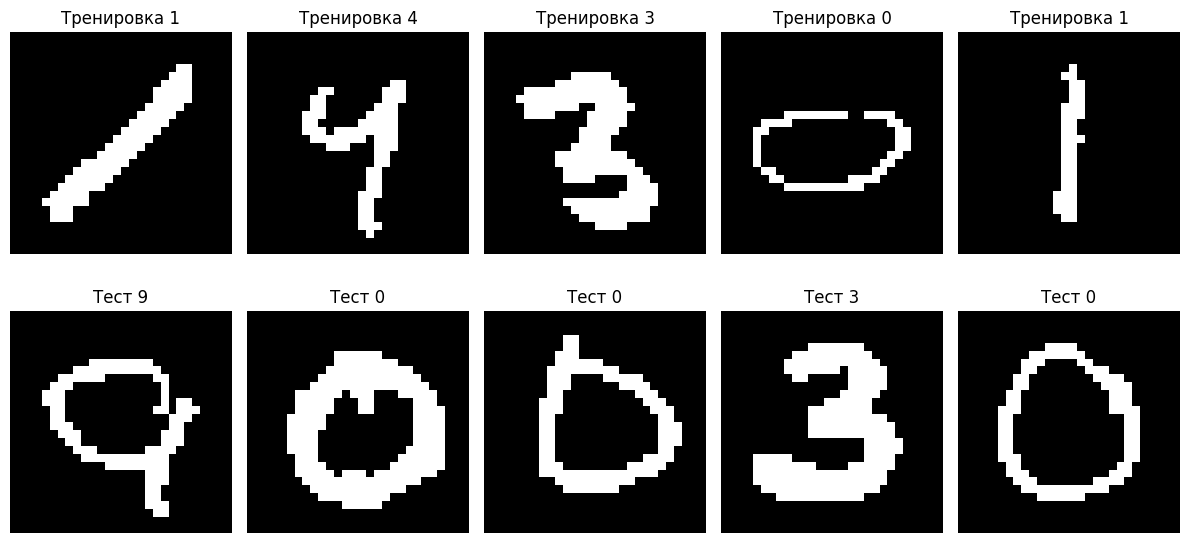

In [5]:
# TODO

# Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# 5 рандомных сэмплов из тренировочных данных
train_indices = random.sample(range(len(train_dataset)), 5)
for i, idx in enumerate(train_indices):
    img, label = train_dataset[idx]
    img = img.squeeze().numpy()
    img = (img + 1) / 2  # Денормализуем
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Тренировка {label}')
    axes[0, i].axis('off')

# 5 рандомных сэмплов из тестовых данных
test_indices = random.sample(range(len(test_dataset)), 5)
for i, idx in enumerate(test_indices):
    img, label = test_dataset[idx]
    img = img.squeeze().numpy()
    img = (img + 1) / 2  # Денормализуем
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Тест {label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [6]:
# TODO: Реализуйте VAE (безусловный)

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),      # 28 → 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),     # 14 → 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z

### Loss

**Задание**: Напишите VAE Loss

In [10]:
# TODO: Реализуйте функцию потерь VAE
def vae_loss(recon, x, mu, logvar):
    # Reconstruction loss: BCE (since output is sigmoid)
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') # TODO
    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # TODO
    return recon_loss + kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [11]:
latent_dim = 32  # MNIST VAEs often use 20–64
epochs = 30  # TODO
lr = 1e-3
img_size = 28
channels = 1

In [12]:
# TODO: Обучите модель
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

min_loss = 1000
best_model_state = None

# Обучение...
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar, _ = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Эпоха [{epoch+1}/{epochs}], Батч [{batch_idx}/{len(train_loader)}], Потери: {loss.item() / len(data):.4f}')
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'====> Эпоха: {epoch+1} Средние потери: {avg_loss:.4f}')
    if avg_loss < min_loss:
        min_loss = avg_loss
        best_model_state = model.state_dict().copy()

print(f'Минимальный loss = {min_loss}')
model.load_state_dict(best_model_state)

Эпоха [1/30], Батч [0/118], Потери: 654.2870
Эпоха [1/30], Батч [100/118], Потери: 196.6518
====> Эпоха: 1 Средние потери: 248.7280
Эпоха [2/30], Батч [0/118], Потери: 188.0396
Эпоха [2/30], Батч [100/118], Потери: 169.3656
====> Эпоха: 2 Средние потери: 175.0537
Эпоха [3/30], Батч [0/118], Потери: 166.0274
Эпоха [3/30], Батч [100/118], Потери: 155.4759
====> Эпоха: 3 Средние потери: 158.9568
Эпоха [4/30], Батч [0/118], Потери: 151.9984
Эпоха [4/30], Батч [100/118], Потери: 150.8824
====> Эпоха: 4 Средние потери: 151.2399
Эпоха [5/30], Батч [0/118], Потери: 146.3535
Эпоха [5/30], Батч [100/118], Потери: 145.7385
====> Эпоха: 5 Средние потери: 146.3174
Эпоха [6/30], Батч [0/118], Потери: 147.7057
Эпоха [6/30], Батч [100/118], Потери: 143.9078
====> Эпоха: 6 Средние потери: 143.0564
Эпоха [7/30], Батч [0/118], Потери: 138.9815
Эпоха [7/30], Батч [100/118], Потери: 138.9722
====> Эпоха: 7 Средние потери: 140.4407
Эпоха [8/30], Батч [0/118], Потери: 135.1546
Эпоха [8/30], Батч [100/118], П

<All keys matched successfully>

### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [13]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake

# Создаем папку для фейковых изображений
fake_dir = 'mnist_vae_fake'
os.makedirs(fake_dir, exist_ok=True)

# Генерация 10000 фейковых изображений
samples_count = 10000
os.makedirs('mnist_vae_fake', exist_ok=True)

with torch.no_grad():
    z = torch.randn(samples_count, model.latent_dim).to(device)
    fake_images = model.decode(z)
    fake_binary = (fake_images > 0.5).float()
    for i in range(samples_count):
        save_image(fake_binary[i], f'{fake_dir}/{fake_dir}_{i:05d}.png')


In [14]:
# Чтобы вычислить FID, запустите в терминале:
%pip install pytorch-fid
!python3 -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
FID:  5.7627929889526115


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /tmp/xdg_cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 62.3MB/s]
100%|██████████| 200/200 [00:37<00:00,  5.39it/s]


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [18]:
# TODO: Реализуйте Conditional VAE — добавьте one-hot класс как вход в encoder и decoder

class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.input_channels = 1 + num_classes  # из-за конкатенации метки

        # Encoder: первый слой принимает 1 + num_classes каналов
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, 4, 2, 1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2 * latent_dim)
        )

        # Decoder: вход — latent_dim + num_classes
        self.decoder_input_dim = latent_dim + num_classes
        self.decoder = nn.Sequential(
            nn.Linear(self.decoder_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # c: [B, num_classes] — one-hot метки
        c = c.view(c.size(0), c.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)  # [B, 1+num_classes, H, W]
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # z: [B, latent_dim], c: [B, num_classes]
        z = torch.cat([z, c], dim=1)  # [B, latent_dim + num_classes]
        return self.decoder(z)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar, z

In [19]:
# TODO: Обучите CVAE

# Подготовка загрузчика данных с метками для CVAE
train_loader_cvae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели CVAE
cvae_model = CVAE(latent_dim=32, num_classes=10).to(device)
cvae_optimizer = optim.Adam(cvae_model.parameters(), lr=1e-3)

# Цикл обучения
epochs_cvae = 20
cvae_model.train()

for epoch in range(epochs_cvae):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader_cvae):
        data = data.to(device)
        target = target.to(device)
        
        # Преобразование меток классов в one-hot кодировку
        c = F.one_hot(target, num_classes=10).float().to(device)
        
        cvae_optimizer.zero_grad()
        recon_batch, mu, logvar, _ = cvae_model(data, c)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        total_loss += loss.item()
        cvae_optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'CVAE Эпоха [{epoch+1}/{epochs_cvae}], Батч [{batch_idx}/{len(train_loader_cvae)}], Потери: {loss.item() / len(data):.4f}')
    
    print(f'CVAE ====> Эпоха: {epoch+1} Средние потери: {total_loss / len(train_loader_cvae.dataset):.4f}')

CVAE Эпоха [1/20], Батч [0/118], Потери: 640.7036
CVAE Эпоха [1/20], Батч [10/118], Потери: 359.4836
CVAE Эпоха [1/20], Батч [20/118], Потери: 282.0281
CVAE Эпоха [1/20], Батч [30/118], Потери: 250.3807
CVAE Эпоха [1/20], Батч [40/118], Потери: 232.1429
CVAE Эпоха [1/20], Батч [50/118], Потери: 225.3878
CVAE Эпоха [1/20], Батч [60/118], Потери: 216.5602
CVAE Эпоха [1/20], Батч [70/118], Потери: 209.3444
CVAE Эпоха [1/20], Батч [80/118], Потери: 203.3069
CVAE Эпоха [1/20], Батч [90/118], Потери: 200.2461
CVAE Эпоха [1/20], Батч [100/118], Потери: 194.5914
CVAE Эпоха [1/20], Батч [110/118], Потери: 188.0993
CVAE ====> Эпоха: 1 Средние потери: 247.2332
CVAE Эпоха [2/20], Батч [0/118], Потери: 185.0392
CVAE Эпоха [2/20], Батч [10/118], Потери: 179.6694
CVAE Эпоха [2/20], Батч [20/118], Потери: 177.9283
CVAE Эпоха [2/20], Батч [30/118], Потери: 177.6453
CVAE Эпоха [2/20], Батч [40/118], Потери: 170.4204
CVAE Эпоха [2/20], Батч [50/118], Потери: 170.2531
CVAE Эпоха [2/20], Батч [60/118], Пот

In [20]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели

num_classes = 10
# Создание директории для фейковых изображений по классам
fake_per_class_dir = 'fake_per_class'
samples_count = 1000
cvae_model.eval()

os.makedirs(fake_per_class_dir, exist_ok=True)

with torch.no_grad():
    for i in range(num_classes):
        class_dir = f'{fake_per_class_dir}/class_{i}'
        os.makedirs(class_dir, exist_ok=True)

        fake_images = cvae_model.decode(torch.randn(samples_count, cvae_model.latent_dim).to(device), torch.eye(num_classes).to(device)[[i]*samples_count])
        fake_binary = (fake_images > 0.5).float()

        for j in range(fake_binary.shape[0]):
            save_image(fake_binary[j], f'{class_dir}/fake_{j:05d}.png')


# TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части

# Создание директории для реальных изображений по классам
real_per_class_dir = 'real_per_class'
real_mnist_samples = 1000

os.makedirs(real_per_class_dir, exist_ok=True)

class_dict = {i: [] for i in range(num_classes)}
for i, (_, label) in enumerate(test_dataset):
    if len(class_dict[label]) < real_mnist_samples:
        class_dict[label].append(i)

for i, id in class_dict.items():
    class_dir = f'{real_per_class_dir}/class_{i}'
    os.makedirs(class_dir, exist_ok=True)
    for k, j in enumerate(id):
        img, _ = test_dataset[j]
        save_image(img, f'{class_dir}/real_{k:05d}.png')
    

Я правда пытался сделать подсчет метрик нормально, но ничего не вышло

In [ ]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями

#for class_idx in range(10):
    #print(f"Класс {class_idx}")
    #real_dir = f'real_per_class/class_{class_idx}'
    #fake_dir = f'fake_per_class/class_{class_idx}'
    #!python3 -m pytorch_fid {real_dir} {fake_dir} --device cuda
    #!python3 -m pytorch_fid {real_per_class_dir}/class_{class_idx} {fake_per_class_dir}/class_{class_idx} --device cuda


И пришлось делать ужасно

In [22]:
print('Class 0')
!python3 -m pytorch_fid real_per_class/class_0 fake_per_class/class_0 --device cuda
print('Class 1')
!python3 -m pytorch_fid real_per_class/class_1 fake_per_class/class_1 --device cuda
print('Class 2')
!python3 -m pytorch_fid real_per_class/class_2 fake_per_class/class_2 --device cuda
print('Class 3')
!python3 -m pytorch_fid real_per_class/class_3 fake_per_class/class_3 --device cuda
print('Class 4')
!python3 -m pytorch_fid real_per_class/class_4 fake_per_class/class_4 --device cuda
print('Class 5')
!python3 -m pytorch_fid real_per_class/class_5 fake_per_class/class_5 --device cuda
print('Class 6')
!python3 -m pytorch_fid real_per_class/class_6 fake_per_class/class_6 --device cuda
print('Class 7')
!python3 -m pytorch_fid real_per_class/class_7 fake_per_class/class_7 --device cuda
print('Class 8')
!python3 -m pytorch_fid real_per_class/class_8 fake_per_class/class_8 --device cuda
print('Class 9')
!python3 -m pytorch_fid real_per_class/class_9 fake_per_class/class_9 --device cuda

Class 0
FID:  14.53710796169868
Class 1


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


FID:  12.269245333548781
Class 2


100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


FID:  22.39358519854423
Class 3


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


FID:  15.782719033831
Class 4


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


FID:  13.339533347309114
Class 5


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


FID:  18.627822473101915
Class 6


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


FID:  11.049864528325315
Class 7


100%|██████████| 20/20 [00:04<00:00,  4.81it/s]


FID:  14.991293581714444
Class 8


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


FID:  18.841995731924925
Class 9


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


FID:  10.275468008883564


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]
